#Imports

In [ ]:
%matplotlib inline

In [ ]:
# FOR GPU
!pip install torch torchvision torchaudio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import librosa

import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
import os
import csv
import IPython




     |████████████████████████████████| 1.9MB 6.4MB/s 


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#Generating Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/Shareddrives/ASRproject/

data	     noise_tensor.pt	     urbannoise.gz
dataset      train-clean-100.tar.gz  UrbanSound8K
LibriSpeech  urbannoise		     voice_tensor.pt


In [ ]:
from torchaudio.datasets import LIBRISPEECH
librispeech_dataset = LIBRISPEECH("/content/drive/Shareddrives/ASRproject",download=True)

In [ ]:
% cd /content/drive/Shareddrives/ASRproject/
!ls

/content/drive/Shareddrives/ASRproject
data	     noise_tensor.pt	     urbannoise.gz
dataset      train-clean-100.tar.gz  UrbanSound8K
LibriSpeech  urbannoise		     voice_tensor.pt


In [ ]:
# generate_data.py

# # global params

# Sample rate to read audio
sample_rate = 8000
# Minimum duration of audio files to consider
min_duration = 1.5
#Frame length for training data
frame_length = 8064
# hop length for clean voice files
hop_length_frame = 8064
# hop length for noise files
hop_length_frame_noise = 5000

#nb of points for fft(for spectrogram computation)
n_fft = 255
#hop length for fft
hop_length_fft = 63


def subsample_list(l,n):
    indices = torch.randperm(len(l))[:n]
    new_l = []
    for i in indices:
        new_l.append(l[i])
    return new_l


def get_voice_files(vdir,num_samples):
    """
        returns all the voice files in librispeech
    """
    voice_files = []

    for r,d,files in os.walk(vdir):
        for f in files:
            if f.endswith(('.mp3','.flac','.wav')):
                voice_files.append(os.path.join(r,f))
    
    return subsample_list(voice_files,num_samples)

def get_noise_files(ndir,classIds,num_samples):
    """
        returns all the noise files in urbannoise8k 
        filters based on classIds
    """
    noise_files = []
    
    for r,d,files in os.walk(ndir):
        for f in files:
            if f.endswith(('.mp3','.flac','.wav')) and f.split('-')[1] in classIds:
                noise_files.append(os.path.join(r,f))
    
    return subsample_list(noise_files,num_samples)



def audios_to_tensor(audio_files,sample_rate,frame_len,hop_len,min_dur):
    """
        return torch tensor for audio files 
    """
    print("Converting Audio to Tensor")
    out = display(IPython.display.Pretty('Starting'),display_id=True)
    ret_tensor = []
    for i,f in enumerate(audio_files):
        # print(i,'/',len(audio_files),end='\r')
        out.update(IPython.display.Pretty(f'{i+1}/{len(audio_files)}'))
        
        waveform,_= librosa.load(str(f),sr=sample_rate)
        waveform = torch.tensor(waveform)
        dur = librosa.get_duration(y=waveform,sr=sample_rate)
        if dur >= min_dur:
            waveform_segments = [waveform[i:i+frame_len] for i in range(
                0,waveform.shape[0]-frame_len+1,hop_len
            )]
            waveform_segments = torch.vstack(waveform_segments)
            ret_tensor.append(waveform_segments)
            
        else :
            print("Skip File: "+f)
    
    return torch.vstack(ret_tensor)




def create_data(voice_tensor,noise_tensor,num_samples,sample_rate,savePath=None):
    """
        generates voice,noise,noisy_voice data by randomly mixing 
        voice and noise data
    """
    flen = voice_tensor.shape[1]
    # voice = torch.zeros((num_samples,flen))
    # noise = torch.zeros((num_samples,flen))
    # noisy_voice = torch.zeros((num_samples,flen))
    print('Creating Data')
    out = display(IPython.display.Pretty('Starting'),display_id=True)
    for i in range(num_samples):
        # print(i,'/',num_samples,end='\r')
        out.update(IPython.display.Pretty(f'{i+1}/{num_samples}'))

        id_voice = np.random.randint(0, voice_tensor.shape[0])
        id_noise = np.random.randint(0, noise_tensor.shape[0])
        level_noise = np.random.uniform(0.2,0.8)
        # voice[i,:] = voice_tensor[id_voice,:]
        # noise[i,:] = level_noise * noise_tensor[id_noise,:]
        # noisy_voice[i:] = voice[i,:] + noise[i,:]
        
        voice = voice_tensor[id_voice,:]
        noise = level_noise * noise_tensor[id_noise,:]
        noisy_voice = voice + noise
        
        if savePath is not None:
            file_name = str(i) + '.wav'
            sf.write(os.path.join(savePath,'voice',file_name),voice,sample_rate,'PCM_24')
            sf.write(os.path.join(savePath,'noise',file_name),noise,sample_rate,'PCM_24')
            sf.write(os.path.join(savePath,'noisy_voice',file_name),noisy_voice,sample_rate,'PCM_24')








In [ ]:
voice_dir = './LibriSpeech/train-clean-100/'
noise_dir = './UrbanSound8K/audio/'
num_voice = 10000
num_noise = 1000

# classes to consider
classId_map = {
    'dog_bark':'3'
}


voice_files = get_voice_files(voice_dir,num_voice)
noise_files = get_noise_files(noise_dir,[classId_map['dog_bark']],num_noise)


print('#voice files',len(voice_files))
print('#noise files',len(noise_files))




#voice files 10000
#noise files 1000


In [ ]:
voice_tensor = audios_to_tensor(voice_files,sample_rate,frame_length,hop_length_frame,min_duration)
noise_tensor = audios_to_tensor(noise_files,sample_rate,frame_length,hop_length_frame_noise,min_duration)

print('Voice Tensor Shape',voice_tensor.shape)
print('Noise Tensor Shape',noise_tensor.shape)




In [ ]:
num_samples=5000
output_dir = './data/'
print('Removing old data',os.system(f'rm -r {output_dir}'))
os.makedirs(output_dir)
os.makedirs(os.path.join(output_dir,'voice'))
os.makedirs(os.path.join(output_dir,'noise'))
os.makedirs(os.path.join(output_dir,'noisy_voice'))

create_data(voice_tensor,noise_tensor,num_samples,sample_rate,output_dir)


Removing old data 0
Creating Data


4999/5000

In [ ]:
# save tensors
torch.save(voice_tensor,'voice_tensor.pt')
torch.save(noise_tensor,'noise_tensor.pt')

In [ ]:
!ls

data	     noise_tensor.pt	     urbannoise.gz
dataset      train-clean-100.tar.gz  UrbanSound8K
LibriSpeech  urbannoise		     voice_tensor.pt


#Speech Dataset Class


In [ ]:
class SpeechDataset(torch.utils.data.Dataset):
  
  def __init__(self, file_list,sample_rate=sample_rate,n_fft=n_fft,hop_length_fft=hop_length_fft):
    
    # store the file names
    self.samples = file_list
    
    noisy_voice_waveforms = torch.vstack([torch.tensor(librosa.load(nvf,sr=sample_rate)[0]) for nvf,_,_ in file_list])
    self.noisy_voice_spectograms = torch.stft(noisy_voice_waveforms,n_fft=n_fft,hop_length=hop_length_fft,return_complex=False)

    voice_waveforms = torch.vstack([torch.tensor(librosa.load(vf,sr=sample_rate)[0]) for _,vf,_ in file_list])
    self.voice_spectograms = torch.stft(voice_waveforms,n_fft=n_fft,hop_length=hop_length_fft,return_complex=False)

    noise_waveforms = torch.vstack([torch.tensor(librosa.load(nf,sr=sample_rate)[0]) for _,_,nf in file_list])
    self.noise_spectograms = torch.stft(noise_waveforms,n_fft=n_fft,hop_length=hop_length_fft,return_complex=False)

    

  def __len__(self):
    return len(self.samples)
    
  def __getitem__(self,i):
    return self.noisy_voice_spectograms[i],self.voice_spectograms[i],self.noise_spectograms[i]



#Prepare Training,Validation,Testing List

In [ ]:
dataset_dir = '/content/drive/Shareddrives/ASRproject/data/'

file_list = [(os.path.join(dataset_dir,'noisy_voice',f'{i}.wav'),
              os.path.join(dataset_dir,'voice',f'{i}.wav'),
              os.path.join(dataset_dir,'noise',f'{i}.wav')
              ) for i in range(5000)]
print(file_list[0])


('/content/drive/Shareddrives/ASRproject/data/noisy_voice/0.wav', '/content/drive/Shareddrives/ASRproject/data/voice/0.wav', '/content/drive/Shareddrives/ASRproject/data/noise/0.wav')


In [ ]:
# %cd  '/content/drive/Shareddrives/ASRproject/'
# # %cd urbannoise
# !file --mime-type urbannoise
IPython.display.Audio(file_list[0][0],rate=sample_rate)

In [ ]:
#  create train val splits
training_list =  file_list[:4000]
validation_list = file_list[4000:]

train_set = SpeechDataset(training_list)
val_set =SpeechDataset(validation_list)

print(train_set[0][0].shape)

torch.Size([128, 128, 2])


In [ ]:
IPython.display.Audio(torch.istft(train_set[0][1],n_fft=255,hop_length=63,length=8064,return_complex=False),rate=sample_rate)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:655: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:787.)
  normalized, onesided, length, return_complex)


#DataLoaders

In [ ]:
BATCH_SIZE = 16
train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE)

# Network

In [ ]:
from torchsummary import summary

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels,kernel_size=3, padding=1),
        nn.LeakyReLU(inplace=True)
    )

def single_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
        nn.LeakyReLU(inplace=True)
    )

class Unet(torch.nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        # manas
        nfilter = 4 #16
        self.dconv_down1 = double_conv(2, nfilter)
        self.dconv_down2 = double_conv(nfilter, 2*nfilter)
        self.dconv_down3 = double_conv(2*nfilter, 4*nfilter)
        self.dconv_down4 = double_conv(4*nfilter, 8*nfilter)
        self.dconv_down5 = double_conv(8*nfilter, 16*nfilter)

        self.maxpool = torch.nn.MaxPool2d(kernel_size=(2,2))
        self.drop = nn.Dropout(p=0.5) #inplace parameter set to false by default, make it true?
        self.upsample = nn.Upsample(scale_factor=(2,2), mode='bilinear', align_corners=True)  # check extra parameters
        
        self.sconv_up4 = single_conv(16*nfilter, 8*nfilter)
        self.dconv_up4 = double_conv(16*nfilter , 8*nfilter)
        self.sconv_up3 = single_conv(8*nfilter, 4*nfilter)
        self.dconv_up3 = double_conv(8*nfilter , 4*nfilter)
        self.sconv_up2 = single_conv(4*nfilter, 2*nfilter)
        self.dconv_up2 = double_conv(4*nfilter , 2*nfilter)
        self.sconv_up1 = single_conv(2*nfilter, nfilter)
        self.dconv_up1 = double_conv(2*nfilter , nfilter)
        
        self.sconv_plast = single_conv(nfilter, 2)
        self.conv_last = nn.Conv2d(2,2,kernel_size=3, padding=1)
    
    def forward(self, x):
        x = x.transpose(1,3)
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        drop4 = self.drop(x)
        x = self.maxpool(drop4)

        x = self.dconv_down5(x)
        x = self.drop(x)

        x = self.upsample(x)
        x = self.sconv_up4(x)
        x = torch.cat([x, drop4], dim=1)
        x = self.dconv_up4(x)

        x = self.upsample(x)
        x = self.sconv_up3(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = self.sconv_up2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = self.sconv_up1(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        
        x = self.sconv_plast(x)
        x = self.conv_last(x)
        # commenting the tanh layer
        # x = torch.tanh(x)
    
        return x.transpose(1,3)



In [ ]:
input = torch.rand(16, 128, 128 , 2).to(device)
unet = Unet().to(device)
# summary(unet, input_size=(128, 128, 2))

print(unet(input).shape)

torch.Size([16, 128, 128, 2])


# TRAINING

In [ ]:
##RE-RUN THIS CODE TO GET A "NEW" NETWORK

LEARNING_RATE = 0.001

## Create an instance of our network
net = Unet()

## Move it to the GPU
net = net.to(device)

# L1 loss
criterion = torch.nn.SmoothL1Loss()

# Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [ ]:
from tqdm import tqdm_notebook

## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 20

epoch_loss, epoch_acc= [], []

for e in range(N_EPOCHS):
  
    print("EPOCH:",e)

    ### TRAINING LOOP
    running_loss = 0
    running_accuracy = 0

    ## Put the network in training mode
    net.train()

    for i, batch in enumerate(tqdm_notebook(train_dl)):

        # Get a batch from the dataloader
        x = batch[0]
        # manas
        noises = batch[2]

        # move the batch to GPU
        x = x.to(device)
        noises = noises.to(device)
        
        # Compute the network output
        y = net(x)

        # Compute the loss
        loss = criterion(y, noises)

        # Reset the gradients
        optimizer.zero_grad()

        # Compute the gradients
        loss.backward()

        # Apply one step of the descent algorithm to update the weights
        optimizer.step()

        ## Compute some statistics
        with torch.no_grad():
            running_loss += loss.item()

    print("Training loss:", running_loss/float(len(train_set)))

    epoch_loss.append(running_loss/len(train_set))


EPOCH: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training loss: 0.003286716925678775
EPOCH: 1



Training loss: 0.0030174228427931665
EPOCH: 2



Training loss: 0.0028899397545028476
EPOCH: 3



Training loss: 0.0027196924556046726
EPOCH: 4



Training loss: 0.0025576982267666607
EPOCH: 5



Training loss: 0.0023880973467603327
EPOCH: 6



Training loss: 0.002098340832744725
EPOCH: 7



Training loss: 0.0019006426993291826
EPOCH: 8



Training loss: 0.001752128490130417
EPOCH: 9



Training loss: 0.0016276551150949672
EPOCH: 10



Training loss: 0.0015575718644540756
EPOCH: 11



Training loss: 0.0015338048732373864
EPOCH: 12



Training loss: 0.0014550085351802409
EPOCH: 13



Training loss: 0.0013697702026693151
EPOCH: 14



Training loss: 0.001341326052090153
EPOCH: 15



Training loss: 0.001285730439936742
EPOCH: 16



Training loss: 0.0012913669581757858
EPOCH: 17



Training loss: 0.0011817290482576937
EPOCH: 18



Training loss: 0.0011716756336390972
EPOCH: 19



Training loss: 0.0011297688626218587


#Plots

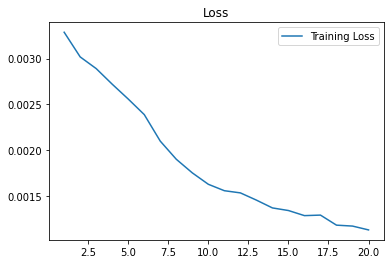

In [ ]:
epochs = range(1,len(epoch_loss)+1)
plt.plot(epochs,epoch_loss,label='Training Loss')
plt.title('Loss')
plt.legend()
plt.show()

#Testing

In [ ]:
# for now test on val set
net.eval()
test_loss = 0

for i,batch in enumerate(val_dl):
  with torch.no_grad():
    # Get a batch from the dataloader
    x = batch[0]
    noises = batch[2]

    # move the batch to GPU
    x = x.to(device)
    noises = noises.to(device)
    
    # Compute the network output
    y = net(x)

    # Compute the loss
    loss = criterion(y, noises)


    test_loss += loss.item()
test_loss = test_loss/len(val_set)

print('Test Loss',test_loss)


Test Loss 0.001234627385623753


#Inference

In [ ]:
test_file = '/content/drive/Shareddrives/ASRproject/data/noisy_voice/4050.wav'

def infer_true_voice(noisy_voice_file):
  wavs = audios_to_tensor([noisy_voice_file],sample_rate,frame_length,hop_length_frame,0)
  specs = torch.stft(wavs,n_fft=n_fft,hop_length=hop_length_fft,return_complex=False)
  
  net.eval()
  x = specs
  x = x.to(device)
  y = net(x)
  print(x.shape,y.shape)
  noise = y.to('cpu')
  noisy_voice = x.to('cpu')
  voice = noisy_voice - noise
  voice_wav = torch.istft(voice,n_fft=n_fft,hop_length=hop_length_fft,length=frame_length,return_complex=False)
  # print(torch.sum(noise))
  return voice_wav.detach().numpy()

true_voice = infer_true_voice(test_file)
IPython.display.Audio(true_voice,rate=sample_rate)

Converting Audio to Tensor


1/1

torch.Size([1, 128, 128, 2]) torch.Size([1, 128, 128, 2])


In [ ]:
torch.save(net.state_dict(),'./model')

In [ ]:
new_net = Unet()
new_net.load_state_dict(torch.load('./model'))

<All keys matched successfully>

In [ ]:
#https://github.com/fgnt/pb_bss/blob/master/pb_bss/evaluation/module_si_sdr.py
def si_sdr(reference, estimation):
    """
    Scale-Invariant Signal-to-Distortion Ratio (SI-SDR)
    Args:
        reference: numpy.ndarray, [..., T]
        estimation: numpy.ndarray, [..., T]
    Returns:
        SI-SDR
    [1] SDR– Half- Baked or Well Done?
    http://www.merl.com/publications/docs/TR2019-013.pdf
    >>> np.random.seed(0)
    >>> reference = np.random.randn(100)
    >>> si_sdr(reference, reference)
    inf
    >>> si_sdr(reference, reference * 2)
    inf
    >>> si_sdr(reference, np.flip(reference))
    -25.127672346460717
    >>> si_sdr(reference, reference + np.flip(reference))
    0.481070445785553
    >>> si_sdr(reference, reference + 0.5)
    6.3704606032577304
    >>> si_sdr(reference, reference * 2 + 1)
    6.3704606032577304
    >>> si_sdr([1., 0], [0., 0])  # never predict only zeros
    nan
    >>> si_sdr([reference, reference], [reference * 2 + 1, reference * 1 + 0.5])
    array([6.3704606, 6.3704606])
    """
    estimation, reference = np.broadcast_arrays(estimation, reference)

    assert reference.dtype == np.float64, reference.dtype
    assert estimation.dtype == np.float64, estimation.dtype

    reference_energy = np.sum(reference ** 2, axis=-1, keepdims=True)

    # This is $\alpha$ after Equation (3) in [1].
    optimal_scaling = np.sum(reference * estimation, axis=-1, keepdims=True) \
        / reference_energy

    # This is $e_{\text{target}}$ in Equation (4) in [1].
    projection = optimal_scaling * reference

    # This is $e_{\text{res}}$ in Equation (4) in [1].
    noise = estimation - projection

    ratio = np.sum(projection ** 2, axis=-1) / np.sum(noise ** 2, axis=-1)
    return 10 * np.log10(ratio)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


array([inf])

In [ ]:
!pip install mir_eval torch
import mir_eval
import torch
import numpy as np

estimated_beats = np.random.rand(16, 500)
reference_beats = np.random.rand(16, 500)
scores = mir_eval.separation.bss_eval_images(reference_beats, estimated_beats,False)

